In [11]:
# Standard libraries; all are available in Anaconda (seaborn is a common free package)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# For nicer plots
sns.set(style="whitegrid")


In [12]:
fred_md_appendix = pd.read_csv("FRED-MD-Appendix.csv")
recession_indicator = pd.read_csv("RecessionIndicator.csv")
transformed_data = pd.read_csv("2023-09-TF.csv")

# Preprocessing
fred_md_appendix.rename(columns={"Unnamed: 0": "id"}, inplace=True)
recession_indicator.rename(columns={"Unnamed: 0": "date", "SVC": "recession_prob"}, inplace=True)
recession_indicator["date"] = pd.to_datetime(recession_indicator["date"])
transformed_data.rename(columns={"sasdate": "date"}, inplace=True)
transformed_data["date"] = pd.to_datetime(transformed_data["date"])


In [13]:
financial_vars = ["S&P 500", "S&P: indust", "S&P div yield", "S&P PE ratio", "VIXCLSx"]
financial_data = transformed_data[["date"] + financial_vars].dropna()

# Merge with recession probability
data = financial_data.merge(recession_indicator, on="date", how="inner")
data["recession_prob_lag1"] = data["recession_prob"].shift(1)
data.dropna(inplace=True)

results = {}
for var in financial_vars:
    # OLS: Financial Variable ~ Lagged Recession Probability
    X_ols = sm.add_constant(data["recession_prob_lag1"])
    y_ols = data[var]
    ols_model = sm.OLS(y_ols, X_ols).fit()
    results[var] = {"OLS": ols_model.summary()}
    
    # AR(1): Financial Variable ~ Its Own Lag
    X_ar1 = sm.add_constant(data[var].shift(1))
    y_ar1 = data[var]
    X_ar1, y_ar1 = X_ar1.dropna(), y_ar1.iloc[1:]
    ar1_model = sm.OLS(y_ar1, X_ar1).fit()
    results[var]["AR(1)"] = ar1_model.summary()

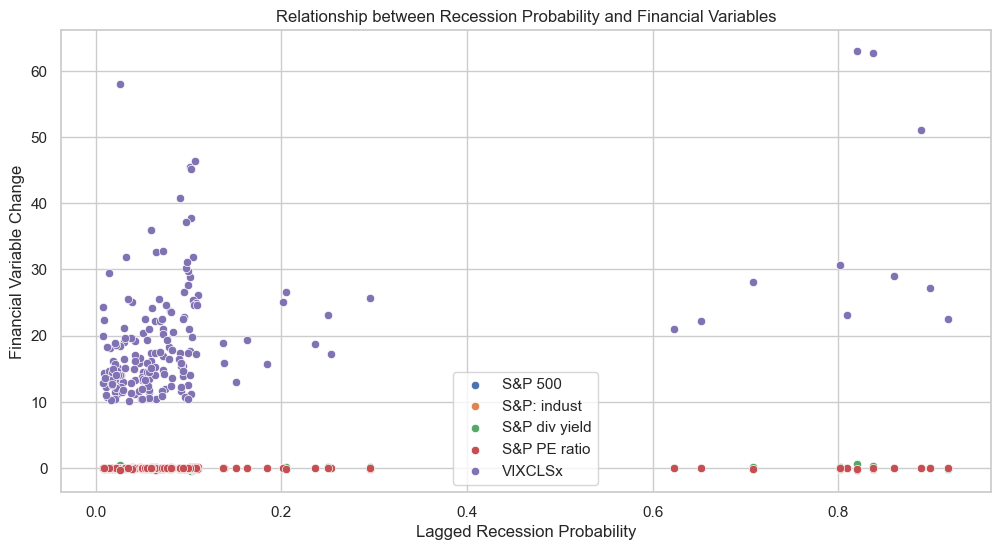



### S&P 500 ###
OLS Regression:
                            OLS Regression Results                            
Dep. Variable:                S&P 500   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     15.67
Date:                Sun, 09 Feb 2025   Prob (F-statistic):           0.000106
Time:                        23:33:56   Log-Likelihood:                 361.34
No. Observations:                 193   AIC:                            -718.7
Df Residuals:                     191   BIC:                            -712.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------


In [14]:
# Visualization
plt.figure(figsize=(12, 6))
for var in financial_vars:
    sns.scatterplot(x=data["recession_prob_lag1"], y=data[var], label=var)
plt.xlabel("Lagged Recession Probability")
plt.ylabel("Financial Variable Change")
plt.legend()
plt.title("Relationship between Recession Probability and Financial Variables")
plt.show()

# Print Results
for var, res in results.items():
    print(f"\n\n### {var} ###")
    print("OLS Regression:")
    print(res["OLS"])
    print("\nAR(1) Model:")
    print(res["AR(1)"])